# **Download library**

In [ ]:
!pip install requests beautifulsoup4 tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.7 MB/s eta 0:00:00


# **Import library**

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urlunparse, urljoin, parse_qsl, urlencode
import tldextract
import time
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, \
                                  sum as spark_sum, abs as spark_abs, \
                                  broadcast
from os import truncate
from pyspark.storagelevel import StorageLevel

# **Crawl data**

In [ ]:
def normalize_url(url):
    if not url:
        return None

    url = url.strip()
    parsed = urlparse(url)

    # Bỏ nếu không có netloc (ví dụ link như "javascript:void(0)")
    if not parsed.netloc and not parsed.path.startswith('/'):
        return None

    # Nếu là link tương đối (chỉ có path), gán netloc để kiểm tra sau
    netloc = parsed.netloc.lower() if parsed.netloc else DOMAIN_NAME

    # Loại bỏ các URL không đúng domain (chỉ cho đúng 'it.tdtu.edu.vn')
    if netloc != DOMAIN_NAME:
        return None

    # Chuẩn hóa scheme + netloc
    parsed = parsed._replace(scheme='https', netloc=netloc)

    # Loại bỏ query và fragment
    parsed = parsed._replace(query='', fragment='')

    clean_url = urlunparse(parsed)

    # Chuẩn hóa dấu '/' cuối
    if clean_url.endswith('/'):
        clean_url = clean_url[:-1]

    return clean_url



def is_valid_url(url):
    if url is None:
        return False
    parsed = urlparse(url)
    if parsed.netloc != DOMAIN_NAME:
        return False
    for ext in IGNORE_EXTENSIONS:
        if parsed.path.lower().endswith(ext):
            return False
    return True

# Domain gốc
BASE_URL = "https://it.tdtu.edu.vn"
DOMAIN_NAME = "it.tdtu.edu.vn"

visited = set()
url_pairs = set()
queue = deque([BASE_URL])

# Các phần mở rộng tệp tĩnh không cần crawl
IGNORE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.svg',
                     '.css', '.js', '.ico', '.pdf', '.mp4', '.avi',
                     '.mov', '.zip', '.rar']
# Bắt đầu crawl
while queue:
    current_url = queue.popleft()
    current_url = normalize_url(current_url)
    if current_url in visited:
        continue
    visited.add(current_url)

    print(f"\n📄 Đang crawl: {current_url}")  # In trang đang crawl

    try:
        response = requests.get(current_url, timeout=5)
        if response.status_code != 200:
            print(f"⚠️ Không truy cập được: {current_url}")
            continue

        soup = BeautifulSoup(response.text, "html.parser")
        sub_links = set()

        for link in soup.find_all("a", href=True):
            raw_href = link.get("href")
            absolute_url = urljoin(current_url, raw_href)
            absolute_url = normalize_url(absolute_url)
            if is_valid_url(absolute_url):
                sub_links.add(absolute_url)
                url_pairs.add((current_url, absolute_url))
                if absolute_url not in visited:
                    queue.append(absolute_url)

        # In các sub-links của trang đó
        print(f"🔗 Tìm được {len(sub_links)} sub-links:")
        for l in sub_links:
            print(f"   ➤ {l}")

    except Exception as e:
        print(f"❌ Lỗi tại {current_url}: {e}")
        continue

# Tạo DataFrame từ kết quả
df = pd.DataFrame(url_pairs, columns=["source", "destination"])

# In 5 dòng đầu
print("\n✅ Crawl hoàn tất. Một số dòng đầu:")
print(df.head())


📄 Đang crawl: https://it.tdtu.edu.vn
🔗 Tìm được 36 sub-links:
   ➤ https://it.tdtu.edu.vn/node/1296
   ➤ https://it.tdtu.edu.vn/giao-duc
   ➤ https://it.tdtu.edu.vn/doi-olympic-tin-hoc-cua-khoa-cntt-tu-hao-gat-hai-thanh-tich-an-tuong-tai-ky-thi-olympic-tin-hoc
   ➤ https://it.tdtu.edu.vn/tin-tuc/hoat-dong-khoa
   ➤ https://it.tdtu.edu.vn
   ➤ https://it.tdtu.edu.vn/tdtu-to-chuc-doi-thoai-sinh-vien-hoc-ky-2-nam-hoc-2024-2025
   ➤ https://it.tdtu.edu.vn/gioi-thieu
   ➤ https://it.tdtu.edu.vn/node/1378
   ➤ https://it.tdtu.edu.vn/ngay-hoi-sinh-vien-it-doanh-nghiep-it-career-day-2025-ket-noi-va-dinh-huong-tuong-lai
   ➤ https://it.tdtu.edu.vn/vien-chuc
   ➤ https://it.tdtu.edu.vn/truong-dai-hoc-ton-duc-thang-ky-ket-hop-tac-voi-tap-doan-ttc
   ➤ https://it.tdtu.edu.vn/iccies
   ➤ https://it.tdtu.edu.vn/tin-tuc/tin-tuc-tdtu
   ➤ https://it.tdtu.edu.vn/tin-tuc-khoa
   ➤ https://it.tdtu.edu.vn/iconclub
   ➤ https://it.tdtu.edu.vn/en
   ➤ https://it.tdtu.edu.vn/tin-tuc
   ➤ https://it.tdtu.edu

<ipython-input-4-feccf13ed921>:74: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(response.text, "html.parser")


🔗 Tìm được 0 sub-links:

📄 Đang crawl: https://it.tdtu.edu.vn/taxonomy/term/65
🔗 Tìm được 32 sub-links:
   ➤ https://it.tdtu.edu.vn/giao-duc
   ➤ https://it.tdtu.edu.vn/doi-olympic-tin-hoc-cua-khoa-cntt-tu-hao-gat-hai-thanh-tich-an-tuong-tai-ky-thi-olympic-tin-hoc
   ➤ https://it.tdtu.edu.vn/serminar-go-japan-diem-den-moi-cho-sinh-vien-cntt
   ➤ https://it.tdtu.edu.vn
   ➤ https://it.tdtu.edu.vn/gioi-thieu
   ➤ https://it.tdtu.edu.vn/sinh-vien-khoa-cntt-tham-quan-kms-technology-kham-pha-cong-nghe-va-co-hoi-nghe-nghiep
   ➤ https://it.tdtu.edu.vn/ngay-hoi-sinh-vien-it-doanh-nghiep-it-career-day-2025-ket-noi-va-dinh-huong-tuong-lai
   ➤ https://it.tdtu.edu.vn/taxonomy/term/65/feed
   ➤ https://it.tdtu.edu.vn/cuoc-thi-hoc-thuat-recursion-coding-game-2024-thanh-cong-ruc-ro
   ➤ https://it.tdtu.edu.vn/vien-chuc
   ➤ https://it.tdtu.edu.vn/dang-ky-tham-gia-phong-trao-nghien-cuu-khoa-hoc-sinh-vien-2024-2025
   ➤ https://it.tdtu.edu.vn/taxonomy/term/65
   ➤ https://it.tdtu.edu.vn/tin-tuc-khoa


In [ ]:
# Lưu ra file CSV
df.to_csv("url_edges.csv", index=False)

In [ ]:
df.count()

,0
source,6373
destination,6373


In [20]:
all_urls = pd.concat([df['source'], df['destination']])
unique_urls = all_urls.unique()
print(f"Số trang web phân biệt: {len(unique_urls)}")

Số trang web phân biệt: 423


# **Create Spark section**

In [ ]:
spark = SparkSession.builder \
    .appName("PageRanking") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# **Load data by Pyspark**

In [ ]:
# Load file CSV vào DataFrame
df = spark.read.csv("url_edges.csv", header=True, inferSchema=True)

# Hiển thị 5 dòng đầu
df.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------+-----------------------------------------+
|source                                                                                                 |destination                              |
+-------------------------------------------------------------------------------------------------------+-----------------------------------------+
|https://it.tdtu.edu.vn/thong-bao-dia-diem-chuc-hoi-dong-bao-ve-khoa-luan-dot-tn-thang-42018            |https://it.tdtu.edu.vn/user/login        |
|https://it.tdtu.edu.vn/khoa-cntt-xet-duyet-de-tai-nghien-cuu-khoa-hoc-sinh-vien-nam-hoc-2023-2024      |https://it.tdtu.edu.vn/gioi-thieu        |
|https://it.tdtu.edu.vn/chung-ket-cuoc-thi-tim-kiem-y-tuong-khoi-nghiep-sinh-vien-tdtu-nam-hoc-2024-2025|https://it.tdtu.edu.vn/iconclub          |
|https://it.tdtu.edu.vn/trien-lam-nckhsv-2023                                                           |https:/

# **PageRanking - the Google algorithm**

In [ ]:
class PageRanking:
    def __init__(self, graph, beta=0.85):
        self.graph = graph
        self.beta = beta
        self.iter_times = []
        self.diff = []


    def initialize_ranks(self):
      # Get list of distinct nodes
      distinct_nodes = self.graph.select(col("source").alias("node")).union(
                  self.graph.select("destination")).distinct()

      # Count a number of distinct nodes
      count_distinct_nodes = distinct_nodes.count()

      return count_distinct_nodes, \
            distinct_nodes.withColumn("r_old", lit(1.0 / count_distinct_nodes))


    def ranking(self, epsilon, max_iter):
      graph = self.graph
      beta = self.beta
      N, df_node_ranks = self.initialize_ranks()

      out_degree = graph.groupBy("source").count() \
                        .withColumnRenamed("count", "out_degree")

      i = 1
      prev_df_node_ranks = None

      while True:
          print(f"=================== Iteration {i} ===================")

          start = time.time()

          df_node_ranks.persist(StorageLevel.MEMORY_AND_DISK)
          if prev_df_node_ranks is not None:
              prev_df_node_ranks.unpersist(blocking=True)

          df_ranks_and_degree = df_node_ranks \
              .withColumn("source", col("node")) \
              .join(out_degree, on="source", how="left") \
              .fillna(0, subset=["out_degree"])

          df_joined = graph.join(df_ranks_and_degree, on="source", how="left")

          df_contrib = df_joined.withColumn("contrib", \
                                            col("r_old") / col("out_degree"))

          df_r_prime_new = df_contrib.groupBy("destination") \
              .agg((spark_sum("contrib") * beta).alias("r_prime_j_new")) \
              .withColumnRenamed("destination", "node")

          df_r_prime_new = df_ranks_and_degree.join(
              df_r_prime_new.select("node", "r_prime_j_new"),
              on="node", how="left"
          ).fillna(0, subset=["r_prime_j_new"])

          S = df_r_prime_new.agg(spark_sum("r_prime_j_new")).first()[0]

          df_r_new = df_r_prime_new \
                .withColumn("r_new", col("r_prime_j_new") + lit((1 - S) / N))

          difference = df_r_new \
              .withColumn("diff", spark_abs(col("r_new") - col("r_old"))) \
              .agg(spark_sum("diff")).first()[0]

          end = time.time()  # ⏱️ Kết thúc đo
          self.iter_times.append(end - start)

          print("Difference:", difference)
          print("\n" * 2)

          self.diff.append(difference)

          if difference < epsilon or i == max_iter:
              # Cleanup
              df_node_ranks.unpersist(blocking=True)
              return df_r_new.select("node", "r_new") \
                              .orderBy(col("r_new").desc())
          else:
              prev_df_node_ranks = df_node_ranks
              df_node_ranks = df_r_new.select(col("node"), \
                                              col("r_new").alias("r_old"))
              i += 1

# **Test**

## Ranking

In [ ]:
pr = PageRanking(df)
ranking = pr.ranking(epsilon=1e-5, max_iter=14)

=================== Iteration 1 ===================
Difference: 1.038375158639824



=================== Iteration 2 ===================
Difference: 0.30147815752660434



=================== Iteration 3 ===================
Difference: 0.052100292646039596



=================== Iteration 4 ===================
Difference: 0.024307906650964585



=================== Iteration 5 ===================
Difference: 0.012960258542850493



=================== Iteration 6 ===================
Difference: 0.009191928108314712



=================== Iteration 7 ===================
Difference: 0.006490583979328324



=================== Iteration 8 ===================
Difference: 0.004639458489975972



=================== Iteration 9 ===================
Difference: 0.0033387278133074185



=================== Iteration 10 ===================
Difference: 0.002423765198560054



=================== Iteration 11 ===================
Difference: 0.0017735334518757652



=================== Iteration 12

In [ ]:
ranking.show(truncate=False)

+-------------------------------------------------+--------------------+
|node                                             |r_new               |
+-------------------------------------------------+--------------------+
|https://it.tdtu.edu.vn                           |0.04004881058444713 |
|https://it.tdtu.edu.vn/en                        |0.036717368762781   |
|https://it.tdtu.edu.vn/giao-duc                  |0.026824831702090542|
|https://it.tdtu.edu.vn/vien-chuc                 |0.025676346818405603|
|https://it.tdtu.edu.vn/iconclub                  |0.0256763468184056  |
|https://it.tdtu.edu.vn/tuyen-sinh                |0.0256763468184056  |
|https://it.tdtu.edu.vn/tin-tuc-khoa              |0.0256763468184056  |
|https://it.tdtu.edu.vn/khoa-hoc-cong-nghe        |0.0256763468184056  |
|https://it.tdtu.edu.vn/gioi-thieu                |0.0256763468184056  |
|https://it.tdtu.edu.vn/giao-vien                 |0.0256763468184056  |
|https://it.tdtu.edu.vn/sinh-vien                 |

## Plot of time and convergence

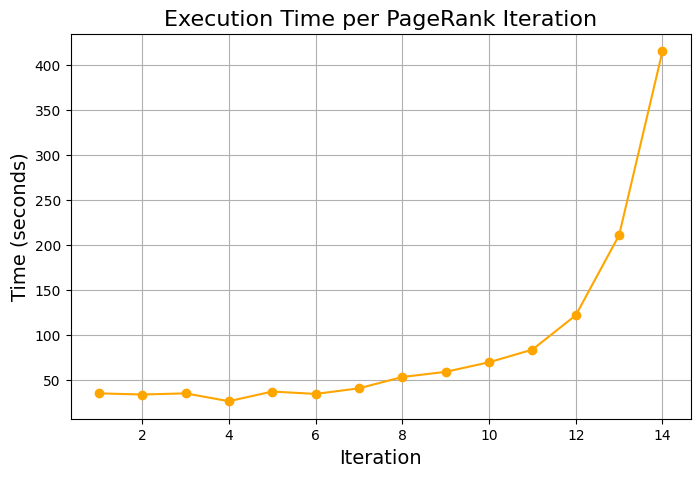

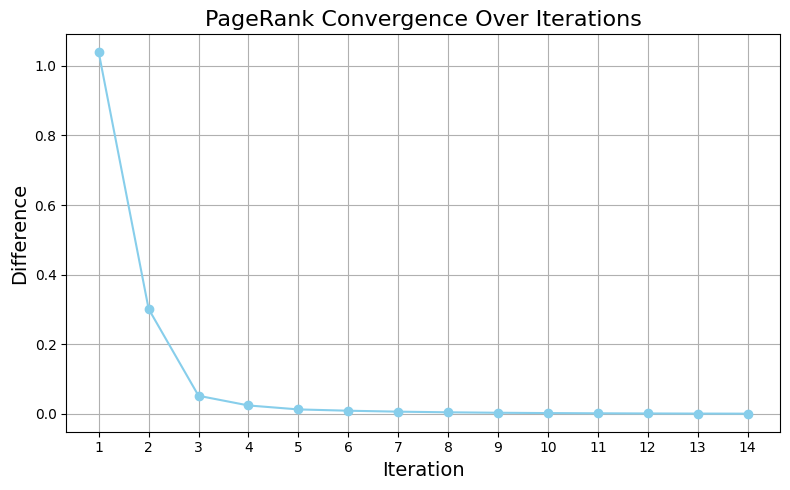

In [ ]:
# Plot of time
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pr.iter_times)+1), pr.iter_times, \
         marker='o', color='orange')
plt.title("Execution Time per PageRank Iteration", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Time (seconds)", fontsize=14)
plt.grid(True)
plt.show()

# Plot of difference
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pr.diff) + 1), pr.diff, marker='o', \
         linestyle='-', color='skyblue')
plt.title("PageRank Convergence Over Iterations", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Difference", fontsize=14)
plt.grid(True)
plt.xticks(range(1, len(pr.diff) + 1))
plt.tight_layout()
plt.show()